In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
import ast
from sklearn.decomposition import PCA

!pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

#### NOTE: 'bacteria_genes.csv' is not on GitHub as its limited by file size. Run 'dataset creation.ipynb' to create the file. Sample file is available as an excel but it doesn't work due to cell size limit.

In [3]:
# read input file and parse the list column 'DB1 genes' to store as list instead of string (format in csv).
# FOR FUTURE: do the parsing when working with 'DB2 genes'. 
# Currently, we work with DB1 only as it has more genes.

df = pd.read_csv('../data/bacteria_genes.csv', index_col='Unnamed: 0')
df['DB1 genes'] = df['DB1 genes'].apply(lambda x: ast.literal_eval(x))
# df['DB2 genes'] = df['DB2 genes'].apply(lambda x: ast.literal_eval(x))
df.head()

,bacteria,disease,levels,taxon id,DB1 genes,DB2 genes,gene subset DB1,gene subset DB2,DB1 length,DB1 subset length,pred
11,Bacteria;Actinobacteria;Actinobacteria;Actinom...,IBS,7,['131109'],"[coaBC, asd, pfp, rlmN, aroB, aroK, nnrD, hflB...","['EII10_10230', 'EII10_08040', 'EII10_07815', ...","{'1': {'dapB', 'uvrB', 'rpmE2', 'nrdH', 'lexA'...",{},1105,778,3
12,Bacteria;Actinobacteria;Actinobacteria;Actinom...,IBS,7,['100469'],"[rlmN, rdgB, prs, asd, aroB, aroK, coaBC, dnaJ...","['EII11_07010', 'EII11_06570', 'EII11_09450', ...","{'0': {'dapB', 'uvrB', 'rpmE2', 'nrdH', 'lexA'...",{},498,780,3
13,Bacteria;Actinobacteria;Actinobacteria;Actinom...,IBS,7,"['888050', '181487']","[coaBC, asd, ilvD, ftsH2, ftsH, rdgB, rlmN, pr...","['HMPREF9004_1386', 'HMPREF9004_0772', 'HMPREF...","{'0': {'dapB', 'hisI', 'hisN', 'uvrB', 'nrdH',...",{},878,781,3
14,Bacteria;Actinobacteria;Actinobacteria;Actinom...,IBS,7,"['272548', '1120941']",[],[],{},{},0,0,1
15,Bacteria;Actinobacteria;Actinobacteria;Actinom...,IBS,7,"['1125717', '1120942', '52768']","[rdgB, asd, aroB, aroK, ddl, gyrB, alaS, map, ...","['HMPREF1317_0706', 'HMPREF1317_1001', 'HMPREF...","{'0': {'dapB', 'uvrB', 'nrdH', 'dnaN', 'lexA',...","{'15': {'glnA_2', 'glnA_1', 'glgX_2', 'glgX_1'...",499,776,3


In [10]:
# Binarize with 0 and 1 for each gene in DB1 genes

mlb = MultiLabelBinarizer()
vec = mlb.fit_transform(df['DB1 genes'])
vectors = pd.DataFrame(vec, columns=mlb.classes_)
vectors.head(5)

,,(BacA),(Blmh),(M),(aspC),(bcaT),(ceoC),(cps),(cypB),(fabB),...,zurR,zurR2,zwf,zwf-2,zwf1,zwf2,zwf3,zwfA1,zwfA2,zwfB
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [11]:
# filter columns based on percent of presence in bacteria. for instance, we choose to work with genes 
# which are present in at least 20% of the bacteria

count = 0
columns = vectors.columns

n = len(df)
percent_10 = int((n*10)/100)
percent_20 = int((n*20)/100)
percent_5 = int((n*5)/100)
percent_2 = int((n*2)/100)
percent_1 = int((n*1)/100)

columns_1 = []
columns_2 = []
columns_5 = []
columns_10 = []
columns_20 = []
columns_rest = []

for column in columns:
    ones = vectors[column].value_counts()[1]
    if (ones <= percent_1):
        columns_1.append(column)
    elif (ones <= percent_2):
        columns_2.append(column)
    elif (ones <= percent_5):
        columns_5.append(column)
    elif (ones <= percent_10):
        columns_10.append(column)
    elif (ones <= percent_20):
        columns_20.append(column)
    else:
        columns_rest.append(column)

In [12]:
#work with genes which are present in at least 20% of the bacteria

compiled_columns = [*columns_20, *columns_rest]
vectors_subset = vectors[compiled_columns]

kmeans = KMeans(n_clusters=10, n_init='auto') 

vec = np.array(vectors_subset)
kmeans.fit(vec)

df['pred'] = kmeans.predict(vec)

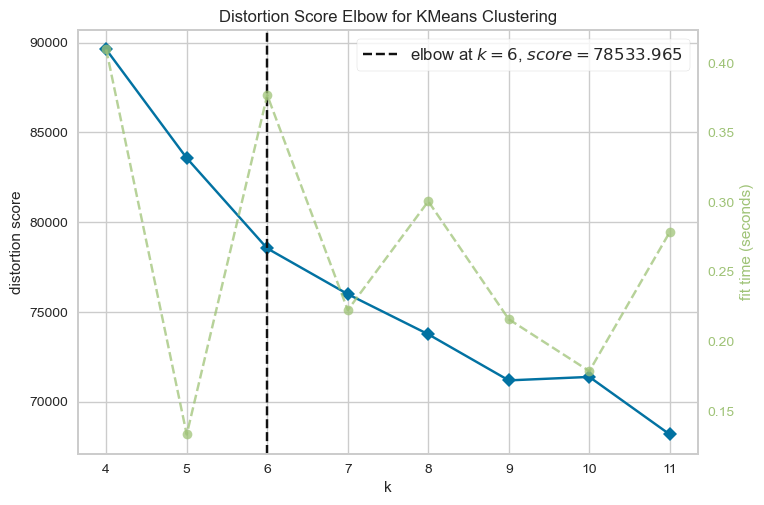

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [16]:
# Look for elblow in curve to find optimal number of clusters. 
# The curve is not very good on raw binarized data!
kmeans = KMeans(n_init=4) 
visualizer = KElbowVisualizer(kmeans, k=(4,12))
visualizer.fit(vec)        
visualizer.show()  

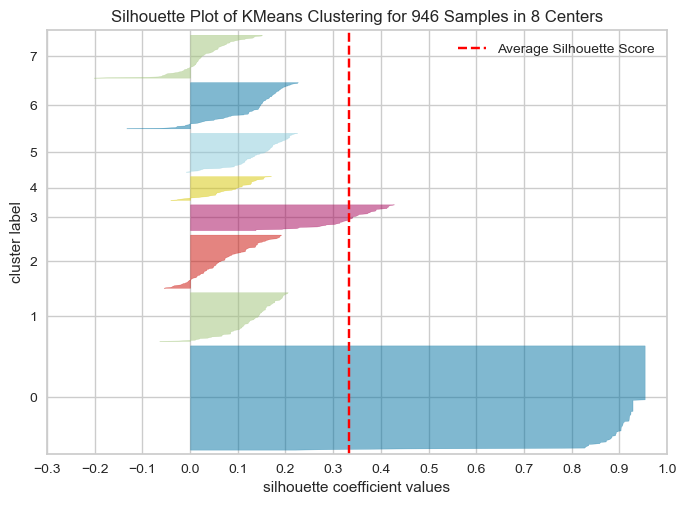

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 946 Samples in 8 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [17]:
# Look at the average Silhoutte Score to check the quality of clusters. The more its towards '1', the better.
# Clustering on raw data is poor.

model = KMeans(n_init='auto')
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(vec)       
visualizer.show()        

In [18]:
#Perform LatentDirichletAllocation to choose genes that belong to similar 'topic' or 'clusters'
# Each row is a topic and the values in DF tells how likely a gene belongs to a topic

lda = LatentDirichletAllocation(n_components=10, verbose=0)
lda_features = lda.fit_transform(vec)
pd.DataFrame(lda.components_, 
             index=list(range(10)), 
             columns=vectors_subset.columns)

,aat,aceE,acnA,acsA,add,addB,ade,ald,amt,anmK,...,xpt,xseA,xseB,xth,xylB,yajC,ybeY,ychF,yidC,zwf
0,18.753479,39.458109,37.128359,42.586357,28.296038,3.415762,0.100058,16.229265,0.100019,4.737585,...,0.100018,90.925321,90.537079,1.505351,43.979374,11.185388,95.527539,96.030479,11.513235,93.633379
1,0.100000,0.100000,0.100016,0.100013,18.783769,17.089505,15.683605,17.280500,4.399222,5.142730,...,70.116823,70.995087,67.741002,26.085654,7.006900,31.177928,70.456890,70.101783,77.320781,58.510526
2,86.024600,53.748917,8.683875,56.428065,11.284818,0.100008,0.100044,0.100028,0.100013,90.635102,...,9.826781,70.309592,73.198253,0.105010,20.524895,5.989852,77.345268,75.778991,76.641240,67.830659
3,16.678158,0.100008,0.576228,3.132467,0.100007,0.100007,0.100009,16.632886,17.875955,0.100011,...,25.890271,35.212647,35.269651,61.516754,3.167542,70.320162,48.141918,48.591934,41.248321,0.940516
4,5.394707,0.100003,0.100006,0.100009,0.100006,0.100007,0.100053,0.100017,0.100014,0.100008,...,60.027940,21.219213,5.553639,0.100008,0.100477,0.100011,72.235820,70.561668,77.150164,58.770373
5,0.100015,0.100000,0.100019,0.100014,39.496425,65.991862,64.118207,16.440164,51.056227,1.952471,...,89.181319,100.431042,102.209077,106.999234,66.881959,100.657971,99.085706,100.143914,32.930651,8.515335
6,0.100010,0.100000,0.100012,0.100007,0.100022,9.075892,64.687718,0.100006,0.100007,7.466800,...,110.466037,131.957667,125.419254,0.100006,63.613067,0.100009,134.050540,130.325749,0.104603,16.612094
7,7.413812,17.092962,59.011480,20.253050,29.638895,17.006710,13.561003,32.917125,37.068537,23.665283,...,12.066381,45.912809,39.211534,60.387970,26.180940,104.268640,39.622891,41.519777,72.154187,26.827559
8,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,...,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
9,21.335219,0.100001,0.100004,0.100019,0.100018,1.020248,18.449302,0.100010,0.100006,0.100011,...,4.224430,40.936623,25.760511,0.100013,8.444846,0.100039,50.433428,51.845705,34.836820,4.259559


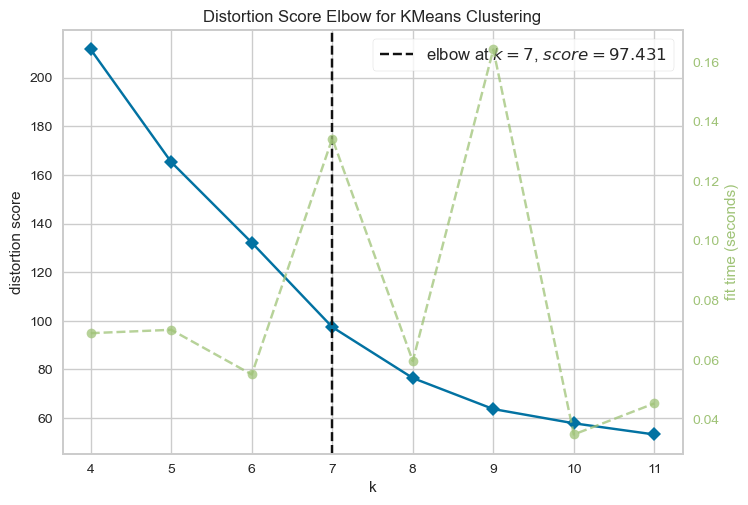

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [28]:
# Fit LDA feature to KMeans. Notice the curve gets better!

kmeans = KMeans(n_init=4) 
visualizer = KElbowVisualizer(kmeans, k=(4,12))
visualizer.fit(lda_features)        
visualizer.show()  

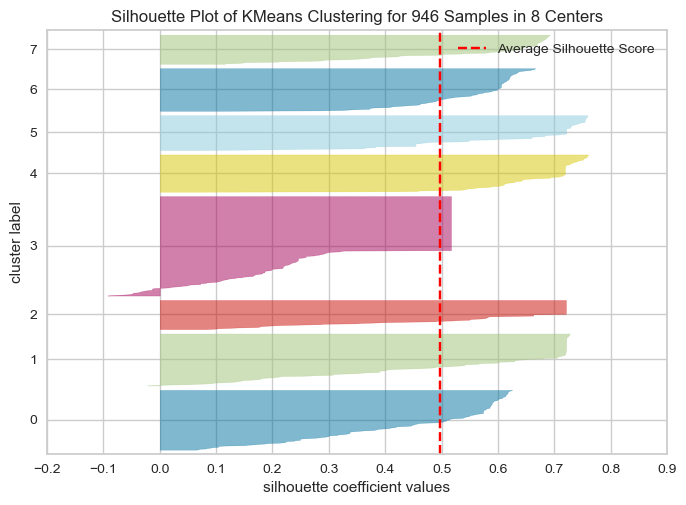

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 946 Samples in 8 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [27]:
# Fit LDA feature to Silhoutte Scoring. The average score gets better.

model = KMeans(n_init='auto')
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(lda_features)        
visualizer.show()

In [29]:
# Perform PCA on the binarized vector and look at the variance explained by the first 10 components

pca = PCA()
pca_components = pca.fit_transform(vec)
explained_variance = pca.explained_variance_ratio_
print(explained_variance[:6])
sum(explained_variance[:10])

[0.3919207  0.07227699 0.05872264 0.0431434  0.03237267 0.02522425]


0.6761710238633427

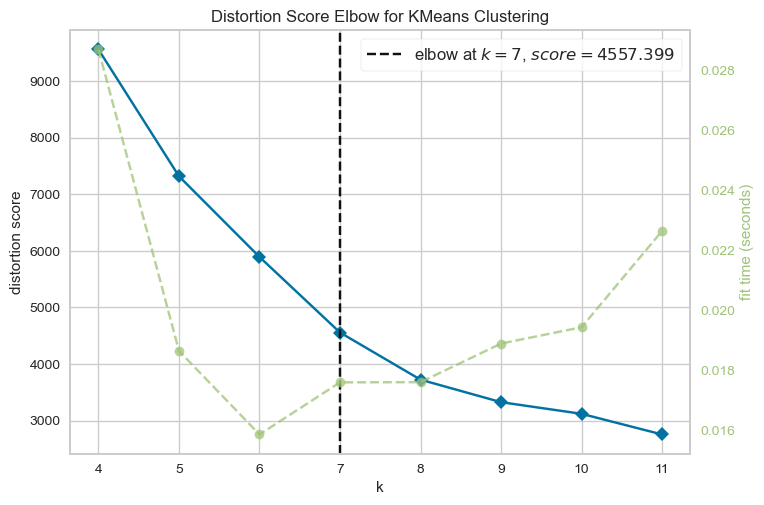

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [35]:
#Plot elbow curve to get the optimal number of clusters using first 3 components of PCA as input.

kmeans = KMeans(n_init=4) 
visualizer = KElbowVisualizer(kmeans, k=(4,12))
visualizer.fit(pca_components[:, :3])  
visualizer.show() 

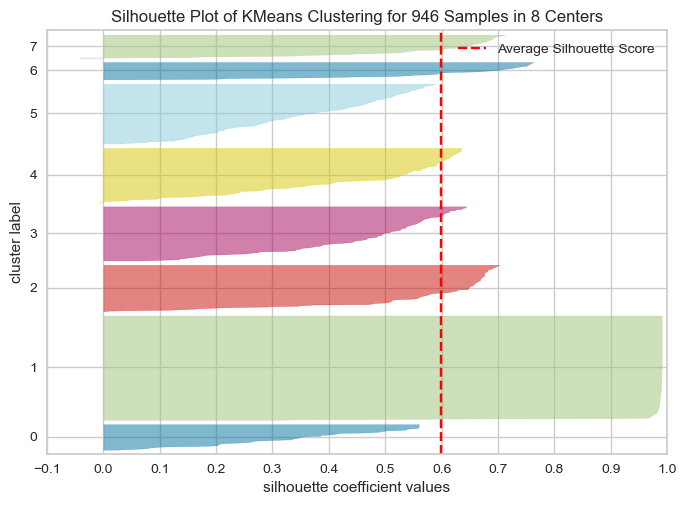

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 946 Samples in 8 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [34]:
#Study Silhoutte Score to get the optimal number of clusters using first 3 components of PCA as input

model = KMeans(n_init='auto')
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(pca_components[:, :3])        
visualizer.show()

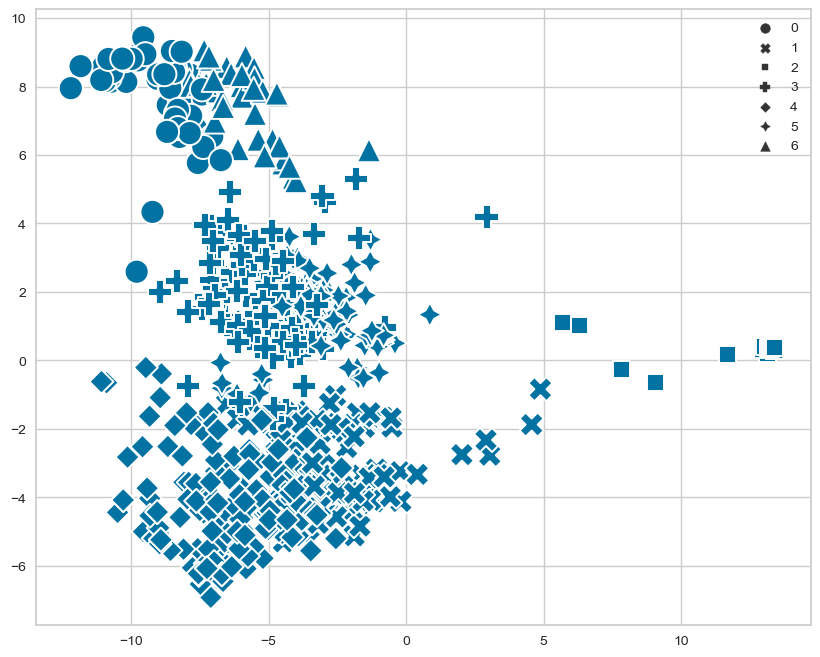

In [38]:
# Used 7 as optimal number of clusters from above studies to perform KMeans on first 3 components

kmeans = KMeans(n_init=7, n_clusters=7, random_state=0)
cluster_labels = kmeans.fit_predict(pca_components[:, :3])
k_means_labels = kmeans.labels_

# Scatter plot the clustering output for the first 2 components of PCA
x_values = pca_components[:, 0]
y_values = pca_components[:, 1]

fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(
    x=x_values, y=y_values, 
    style=k_means_labels,
    s=300,
    ax=ax
)
plt.show()